# (phase 1) 03 Class overlap mitigation

Once the overlapping regions and/or instances have been accurately identified, it is possible to try to mitigate its impact on the performance. To do so, there are three (two) approaches implemented in this study:

- 1. Discarding scheme (not implemented)
- 2. Separating scheme 
- 3. Merging scheme

## Load data and packages

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from mpl_toolkits.mplot3d import Axes3D
import gower
import prince
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, recall_score, roc_auc_score, roc_curve, average_precision_score,accuracy_score, precision_score
from sklearn.linear_model import LogisticRegression
from collections import Counter,  defaultdict
from typing import List
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from tqdm import tqdm
from scipy.spatial.distance import euclidean, hamming
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import BallTree
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import NearestNeighbors
from joblib import dump, load
import scipy.stats
import lightgbm as lgb
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import shap as shap


# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *
from auxFuns.class_overlap import *


In [9]:
import auxFuns.EDA 
importlib.reload(auxFuns.EDA)

import auxFuns.modelling
importlib.reload(auxFuns.modelling)

import auxFuns.class_overlap
importlib.reload(auxFuns.class_overlap)

<module 'auxFuns.class_overlap' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\class_overlap.py'>

In [10]:
# Load phase 1 data
raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

# Phase 1 data
rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup_seasons_prevTest_v2.csv',low_memory=False)
rsv_predictors_phase1_df = make_it_categorical_v2(rsv_predictors_df_v2)

In [11]:
# Following the model selection step, these are the final features taken for modelling
selected_features_v2 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'key_comorbidities','Pneumonia',
                     'season','month_of_the_test','multiple_tests',
                     'BPA','BPAI']
selected_features_v2.append('RSV_test_result')

df_modelling_phase1 = rsv_predictors_phase1_df[selected_features_v2]

df_modelling_phase1.shape

(86058, 21)

In [27]:
X = df_modelling_phase1.drop(['RSV_test_result'], axis = 1)
y = df_modelling_phase1.RSV_test_result

random_seed = 42

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_seed)

In [7]:
X_train.shape, X_validation.shape, y_train.value_counts(), y_validation.value_counts()

((68846, 20),
 (17212, 20),
 Negative    66723
 Positive     2123
 Name: RSV_test_result, dtype: int64,
 Negative    16681
 Positive      531
 Name: RSV_test_result, dtype: int64)

## 1. Separating scheme
- Identify overlapping and non overlapping regions using the n1 approach
- Fit models independently
- Evaluate the models independently


In [13]:
# 1.1. Identify overlapping and non overlapping regions using n1 approach
X_all = pd.get_dummies(pd.concat([X_train, X_validation], axis = 0))
labels_all = pd.concat([y_train,y_validation], axis = 0)

same_class_neighbours_dict, N1_metric_dict, dist_matrix, ind = calculate_same_neighbours_and_N1(X = X_all, y = labels_all, n_neighbours = 2)

len_train = X_train.shape[0]
len_validation = X_validation.shape[0]

same_class_neighbours_dict_training = {key: value[:len_train] for key, value in same_class_neighbours_dict.items()}
same_class_neighbours_dict_validation = {key: value[-len_validation:] for key, value in same_class_neighbours_dict.items()}

Build-up of the ball tree ...
Finding closest 1 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.052185735201840666
Done!


In [43]:
# Better approach: find same_class_neighbours separately in training and validation sets
print('\nCalculating overlapping instances in TRAINING data ...')
same_class_neighbours_dict_training, N1_training, __, __ = calculate_same_neighbours_and_N1(X = pd.get_dummies(X_train), y = y_train, n_neighbours = 2)

print('\nCalculating overlapping instances in VALIDATION data ...')
same_class_neighbours_dict_validation, __, __, __ = calculate_same_neighbours_and_N1(X = pd.get_dummies(X_validation), y = y_validation, n_neighbours = 2)



Calculating overlapping instances in TRAINING data ...
Build-up of the ball tree ...
Finding closest 1 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.053496208930075784
Done!

Calculating overlapping instances in VALIDATION data ...
Build-up of the ball tree ...
Finding closest 1 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.04729258656751101
Done!


In [44]:
# 1.2. Fit of TWO independent models (one in the overlapping and one in the non-overlapping regions) in the TRAINING SET
print('\n------------------')
print('-------------------')
n_neighbours_to_determine_overlap = 1
print('Fitting model on trainig data exclusively')
print(f'Building the two models using as reference {n_neighbours_to_determine_overlap} number of neighbours to determine overlap')

overlapping_mask_training = ~same_class_neighbours_dict_training[n_neighbours_to_determine_overlap]

model_nonOverlapping, model_Overlapping = only_build_2overlapping_models(X = X_train, labels = y_train, is_overlapping = overlapping_mask_training, 
                                                                        random_seed = 42,
                                                                        model_class_non_overlapping = RandomForestClassifier(),
                                                                        param_grid_non_overlapping = {'n_estimators': [7, 14],'max_depth': [10, 20],'min_samples_split': [5, 10],'min_samples_leaf': [1, 4]},
                                                                        cost_sensitive_non_overlapping = False, weight_dict_non_overlapping = {'Negative': 1, 'Positive': 15},
                                                                        model_class_overlapping = RandomForestClassifier(),
                                                                        param_grid_overlapping = {'n_estimators': [7, 14],'max_depth': [10, 20],'min_samples_split': [5, 10],'min_samples_leaf': [1, 4]},
                                                                        cost_sensitive_overlapping = False, weight_dict_overlapping = {'Negative': 1, 'Positive': 15})


------------------
-------------------
Fitting model on trainig data exclusively
Building the two models using as reference 1 number of neighbours to determine overlap
----------------
Building non-overlapping model ...
Training model ... RandomForestClassifier(random_state=42)
Best training parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 7}
Best training f1-score:  0.5880236463393498
----------------
Building (yes) overlapping model ...
Training model ... RandomForestClassifier(random_state=42)
Best training parameters:  {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 7}
Best training f1-score:  0.5025296060993905


In [ ]:
# Save these
phase1_models_path = os.getcwd() + '/models/models_phase1'
dump(model_nonOverlapping, phase1_models_path + '/nonOverlapping_rfc_8020_20230903.joblib')
dump(model_Overlapping, phase1_models_path + '/Overlapping_rfc_8020_20230903.joblib')

In [45]:
## Probs in the validation setting
X_validation_dummies = pd.get_dummies(X_validation)

y_probs_validation_nonOverlapping_model = model_nonOverlapping.predict_proba(X_validation_dummies)[:,1]

y_probs_validation_Overlapping_model = model_Overlapping.predict_proba(X_validation_dummies)[:,1]

Optimal threshold: 0.18
Optimal f1: 0.6594594594594594


AUC Score: 0.9693971658949576
Precision / Positive predictive value: 0.5589005235602095
Specificity: 0.979797374258138
Recall / sensitivity: 0.8041431261770244
Negative predictive value: 0.9936770428015564
Accuracy: 0.97437834069254
F-1: 0.6594594594594594
Precision-Recall AUC: 0.6752810455702498


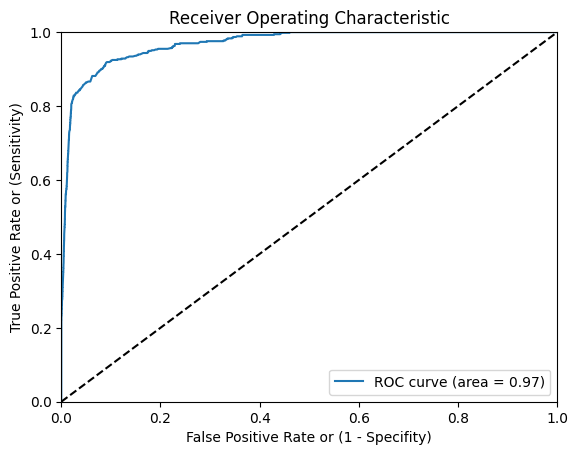

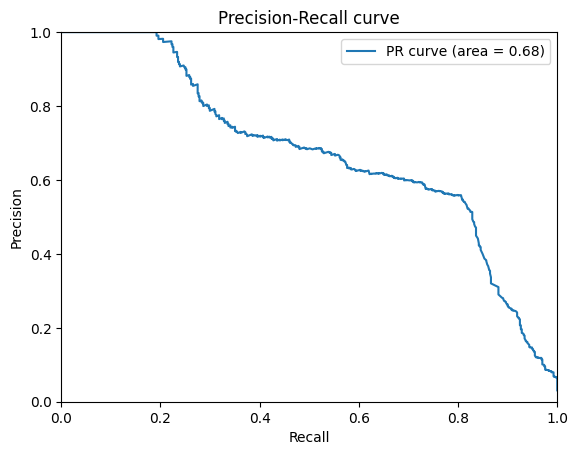

In [64]:
## 1.3. Evaluate the model
### Aggregated model
true_overlapping_mask = ~same_class_neighbours_dict_validation[1]

y_probs_all = (true_overlapping_mask * y_probs_validation_Overlapping_model) + ((~true_overlapping_mask) * y_probs_validation_nonOverlapping_model)

optimal_threshold = find_optimal_moving_threshold_from_probas(y_probs=y_probs_all, y_test=y_validation, verbose = True)

roc_auc_all, __, __, __, __, __, f1, pr_auc_all, fpr_all, tpr_all, recalls_all, precisions_all = calculate_performance_metrics_from_probas(y_probs = y_probs_all, y_test = y_validation, 
                                                                    threshold= optimal_threshold, print_roc = True, print_pr = True, verbose = True)


In [65]:
# Performance of OVERLAPPING model
y_probs_overlapping = y_probs_all[true_overlapping_mask]
y_validation_overlapping = y_validation[true_overlapping_mask]

optimal_threshold = find_optimal_moving_threshold_from_probas(y_probs=y_probs_overlapping, y_test=y_validation_overlapping, verbose = True)

roc_auc_overlapping, __, __, __, __, __, f1, pr_auc_overlapping, fpr_overlapping, tpr_overlapping, recalls_overlapping, precisions_overlapping = calculate_performance_metrics_from_probas(y_probs = y_probs_overlapping, y_test = y_validation_overlapping, 
                                                                    threshold= optimal_threshold, print_roc = False, print_pr = False, verbose = True)

Optimal threshold: 0.18
Optimal f1: 0.6716279069767441


AUC Score: 0.683483204698801
Precision / Positive predictive value: 0.5179340028694405
Specificity: 0.22935779816513763
Recall / sensitivity: 0.955026455026455
Negative predictive value: 0.8547008547008547
Accuracy: 0.5663390663390664
F-1: 0.6716279069767441
Precision-Recall AUC: 0.6652866260764146


In [66]:
# Performance of non-overlapping model
y_probs_nonOverlapping = y_probs_all[~true_overlapping_mask]
y_validation_nonOverlapping = y_validation[~true_overlapping_mask]

optimal_threshold = find_optimal_moving_threshold_from_probas(y_probs=y_probs_nonOverlapping, y_test=y_validation_nonOverlapping, verbose = True)

roc_auc_nonoverlapping, __, __, __, __, __, f1, pr_auc_nonoverlapping, fpr_nonoverlapping, tpr_nonoverlapping, recalls_nonoverlapping, precisions_nonoverlapping = calculate_performance_metrics_from_probas(y_probs = y_probs_nonOverlapping, y_test = y_validation_nonOverlapping, 
                                                                    threshold= optimal_threshold, print_roc = False, print_pr = False, verbose = True)

Optimal threshold: 0.22
Optimal f1: 0.6027397260273972


AUC Score: 0.9273334982910779
Precision / Positive predictive value: 1.0
Specificity: 1.0
Recall / sensitivity: 0.43137254901960786
Negative predictive value: 0.9946730345334313
Accuracy: 0.9946944749359679
F-1: 0.6027397260273972
Precision-Recall AUC: 0.488328029850964


In [51]:
# Performance of the aggregated model
pred_nonOverlapping = ['Positive' if lab == True else 'Negative' for lab in (y_probs_nonOverlapping > 0.71)] # these are the optimal thresholds identified previously
pred_overlapping = ['Positive' if lab == True else 'Negative' for lab in (y_probs_overlapping > 0.24)]

pred = pred_nonOverlapping + pred_overlapping
y_probs = np.concatenate([y_probs_nonOverlapping, y_probs_overlapping])
true = pd.concat([y_validation_nonOverlapping, y_validation_overlapping], axis = 0)

accuracy = accuracy_score(true, pred)
precision = precision_score(true, pred, pos_label = 'Positive')
recall = recall_score(true, pred, pos_label = 'Positive')
f1 = f1_score(true, pred, pos_label = 'Positive')
roc_auc = roc_auc_score(true, y_probs)
spec = specificity(true, pred)
npv = negative_predictive_value(true, pred)
precision_curve, recall_curve, _ = precision_recall_curve(true, y_probs, pos_label = 'Positive')
pr_auc = auc(recall_curve, precision_curve)

print('\n-------')
print('Performance metrics of the aggregated model')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall/Sensitivity: {recall}")
print(f"F1-score: {f1}")
print(f"ROC AUC: {roc_auc}")
print(f"Specificity: {spec}")
print(f"Negative Predictive Value: {npv}")
print(f"Precision-Recall AUC: {pr_auc}")


-------
Performance metrics of the aggregated model
Accuracy: 0.9745526376946316
Precision: 0.563265306122449
Recall/Sensitivity: 0.7796610169491526
F1-score: 0.6540284360189573
ROC AUC: 0.9693971658949576
Specificity: 0.9807565493675439
Negative Predictive Value: 0.9928991928142259
Precision-Recall AUC: 0.6752810455702498


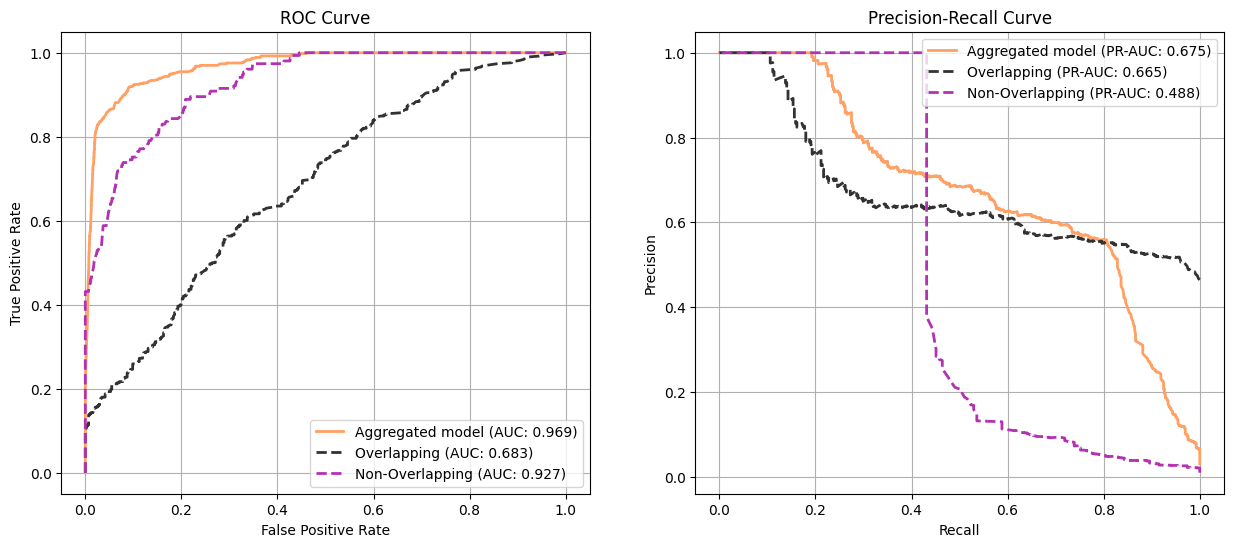

In [73]:
# Plot the resultings roc and precision-recall curves
# Create subplots: two plots horizontally aligned
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

light_red = (0.7, 0.5, 0.5)
light_blue = (0.4,0.4, 0.9)
light_green = (0.4,0.9, 0.4)
light_black = (50/255, 50/255, 50/255)
light_purple = (178/255, 50/255, 178/255)
light_yellow = (255/255, 160/255, 100/255)

# ROC curves
ax1.plot(fpr_all, tpr_all, label=f'Aggregated model (AUC: {roc_auc_all:.3f})', linestyle='-', linewidth=2, c = light_yellow)
ax1.plot(fpr_overlapping, tpr_overlapping, label=f'Overlapping (AUC: {roc_auc_overlapping:.3f})', linestyle='--', linewidth=2, c = light_black)
ax1.plot(fpr_nonoverlapping, tpr_nonoverlapping, label=f'Non-Overlapping (AUC: {roc_auc_nonoverlapping:.3f})', linestyle='--', linewidth=2, c = light_purple)

ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right')
ax1.grid(True)

# Precision-Recall curves
ax2.plot(recalls_all, precisions_all, label=f'Aggregated model (PR-AUC: {pr_auc_all:.3f})', linestyle='-', linewidth=2, c = light_yellow)
ax2.plot(recalls_overlapping, precisions_overlapping, label=f'Overlapping (PR-AUC: {pr_auc_overlapping:.3f})', linestyle='--', linewidth=2, c = light_black)
ax2.plot(recalls_nonoverlapping, precisions_nonoverlapping, label=f'Non-Overlapping (PR-AUC: {pr_auc_nonoverlapping:.3f})', linestyle='--', linewidth=2, c = light_purple)

ax2.set_title('Precision-Recall Curve')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc='upper right')
ax2.grid(True)

# Show the plot
plt.show()


## 2. Merging scheme

In this case, a two stage classifier is trained to identify first overlappig points and second to classify them as positive or negative. Steps:

1. Identify the overlapping and nonoverlapping regions in test and train data

In [ ]:
# 1. Identify overlapping and non overlapping

print('\nCalculating overlapping instances in TRAINING data ...')
same_class_neighbours_dict_training, N1_training, __, __ = calculate_same_neighbours_and_N1(X = pd.get_dummies(X_train), y = y_train, n_neighbours = 2)

print('\nCalculating overlapping instances in VALIDATION data ...')
same_class_neighbours_dict_validation, __, __, __ = calculate_same_neighbours_and_N1(X = pd.get_dummies(X_validation), y = y_validation, n_neighbours = 2)

overlapping_mask_train = ~same_class_neighbours_dict_training[1]
overlapping_mask_validation = ~same_class_neighbours_dict_validation[1]

In [107]:
# 2.  Train a general purpose model to predict RSV positivity.
# This model will then be used in non-overlapping instances
random_seed = 42
cost_sensitive = True
if cost_sensitive:
    weight_dict = {"Negative": 1,
                "Positive": 5}
    model_class = RandomForestClassifier(class_weight= weight_dict,
                                        random_state= random_seed)
else:
    model_class = RandomForestClassifier(class_weight= None,
                                        random_state= random_seed)
    
param_grid = {
    'n_estimators': [4, 7, 14, 25],
    'max_depth': [10, 20],
    'min_samples_split': [3, 5, 10],
    'min_samples_leaf': [1, 4]
}

target_scorer = make_scorer(f1_score, average='macro')
n_cv_folds = 5

general_model = train_model_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                    X_train = pd.get_dummies(X_train), y_train = y_train)

Training model ... RandomForestClassifier(class_weight={'Negative': 1, 'Positive': 5},
                       random_state=42)
Best training parameters:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 25}
Best training f1-score:  0.6809558384656919


In [101]:
# 3. Train a first-stage model to identify overlapping instances

## 3.1. Train a first stage model to distinguish between overlapping and non overlapping instances
random_seed = 42
cost_sensitive = False
if cost_sensitive:
    weight_dict = {0: 1, 1: 10}
    model_class = lgb.LGBMClassifier(class_weight=weight_dict, random_state=random_seed)
else:
    model_class = lgb.LGBMClassifier(random_state=random_seed)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 62],
    'max_depth': [5, 10, 15]
}

target_scorer = make_scorer(f1_score, average='macro')
n_cv_folds = 5

first_stage_model = train_model_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                    X_train = pd.get_dummies(X_train), y_train = overlapping_mask_train)

Training model ... LGBMClassifier(random_state=42)
Best training parameters:  {'learning_rate': 0.2, 'max_depth': 15, 'n_estimators': 200, 'num_leaves': 62}
Best training f1-score:  0.7355805647768546


In [106]:
## 3.2. Evaluate the first-stage model
y_probs_of_overlapping =  first_stage_model.predict_proba(pd.get_dummies(X_validation))[:,1]
aux_overlapping_validation =  ['Positive' if boo == True else 'Negative' for boo in overlapping_mask_validation]

optimal_threshold_first_stage = find_optimal_moving_threshold_from_probas(y_probs = y_probs_of_overlapping, y_test=aux_overlapping_validation, verbose = True)

__, __, __, __, __, __, f1, __, __, __, __, __ = calculate_performance_metrics_from_probas(y_probs = y_probs_of_overlapping, y_test = aux_overlapping_validation, 
                                                                    threshold= optimal_threshold_first_stage, print_roc = False, print_pr = False, verbose = True)

Optimal threshold: 0.09
Optimal f1: 0.1566265060240964


AUC Score: 0.6797119817152748
Precision / Positive predictive value: 0.11292073832790445
Specificity: 0.9003537016709354
Recall / sensitivity: 0.25552825552825553
Negative predictive value: 0.9605725439167209
Accuracy: 0.8698582384382989
F-1: 0.1566265060240964
Precision-Recall AUC: 0.10203850618826663


The performance of the first stage model is not promising, as it is challenging to identify overlapping instances

In [109]:
# 4. Train a second-stage model
# This model's goal is to determine the Positive/Negative aspect of the overlapping instances, exclusively
cost_sensitive_second_stage_model = True
if cost_sensitive_second_stage_model:
    weight_dict = {"Negative": 1,
                "Positive": 5}
    model_class = RandomForestClassifier(class_weight= weight_dict,
                                        random_state= random_seed)
else:
    model_class = RandomForestClassifier(class_weight= None,
                                        random_state= random_seed)
    
param_grid = { 'n_estimators': [4, 7, 14, 25], 'max_depth': [10, 20],
    'min_samples_split': [3, 5, 10], 'min_samples_leaf': [1, 4] }

target_scorer = make_scorer(f1_score, average='macro')
n_cv_folds = 5

# See how this model is trained exclusively on the overlapping data
second_stage_model = train_model_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                    X_train = pd.get_dummies(X_train.loc[overlapping_mask_train,:]), y_train = y_train[overlapping_mask_train])

Training model ... RandomForestClassifier(class_weight={'Negative': 1, 'Positive': 5},
                       random_state=42)
Best training parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 14}
Best training f1-score:  0.6266365172923344


In [115]:
# 5. Make the final predictions and evaluate the combined model
# First-stage predictions to identify overlapping (and non-overlapping) instances
y_pred_of_overlapping = first_stage_model.predict_proba(pd.get_dummies(X_validation))[:,1]

overlapping_pred_idx = [True if (prob > optimal_threshold_first_stage) else False for prob in y_pred_of_overlapping]
non_overlapping_pred_idx = [False if (prob > optimal_threshold_first_stage) else True for prob in y_pred_of_overlapping]

## Second-stage predictions for 'overlapping' instances
y_pred_second_stage = second_stage_model.predict_proba(pd.get_dummies(X_validation[overlapping_pred_idx]))[:,1]

## General model predictions for 'non-overlapping' instances
y_pred_general = general_model.predict_proba(pd.get_dummies(X_validation[non_overlapping_pred_idx]))[:,1]

# Combine predictions
y_probs_all = np.zeros_like(y_validation)
y_probs_all[overlapping_pred_idx] = y_pred_second_stage
y_probs_all[non_overlapping_pred_idx] = y_pred_general

# Evaluate the final predictions
optimal_threshold_all_merging = find_optimal_moving_threshold_from_probas(y_probs = y_probs_all, y_test=y_validation, verbose = True)

__, __, __, __, __, __, f1, __, __, __, __, __ = calculate_performance_metrics_from_probas(y_probs = y_probs_all, y_test = y_validation, 
                                                                    threshold= optimal_threshold_all_merging, print_roc = False, print_pr = False, verbose = True)


Optimal threshold: 0.9
Optimal f1: 0.3505747126436782


AUC Score: 0.7889579368522731
Precision / Positive predictive value: 0.7393939393939394
Specificity: 0.9974222168934717
Recall / sensitivity: 0.2297551789077213
Negative predictive value: 0.9760075086525488
Accuracy: 0.973739251684871
F-1: 0.3505747126436782
Precision-Recall AUC: 0.3187042430149219


This 'merging' scheme provides unsatisfactory results. The source of these bad results comes from the so-called 'first stage model', as it fails to detect accurately between overlapping and non-overlapping instances.

## 3. Analysis of the results: drivers of Positivity

- Feature importance (in the nonOverlapping region) and in the overlapping region

In [8]:
# Load the models if needed 
phase1_models_path = os.getcwd() + '/models/models_phase1'

# Load the models
model_nonOverlapping = load(phase1_models_path + '/nonOverlapping_rfc_8020_20230903.joblib')
model_Overlapping = load(phase1_models_path + '/Overlapping_rfc_8020_20230903.joblib')

#### 3.1.  Feature importances

In [41]:
from joblib import dump, load
phase1_models_path = os.getcwd() + '/models/models_phase1'

model_nonOverlapping = load(phase1_models_path + '/nonOverlapping_rfc_8020_20230903.joblib')
model_Overlapping = load(phase1_models_path + '/Overlapping_rfc_8020_20230903.joblib')

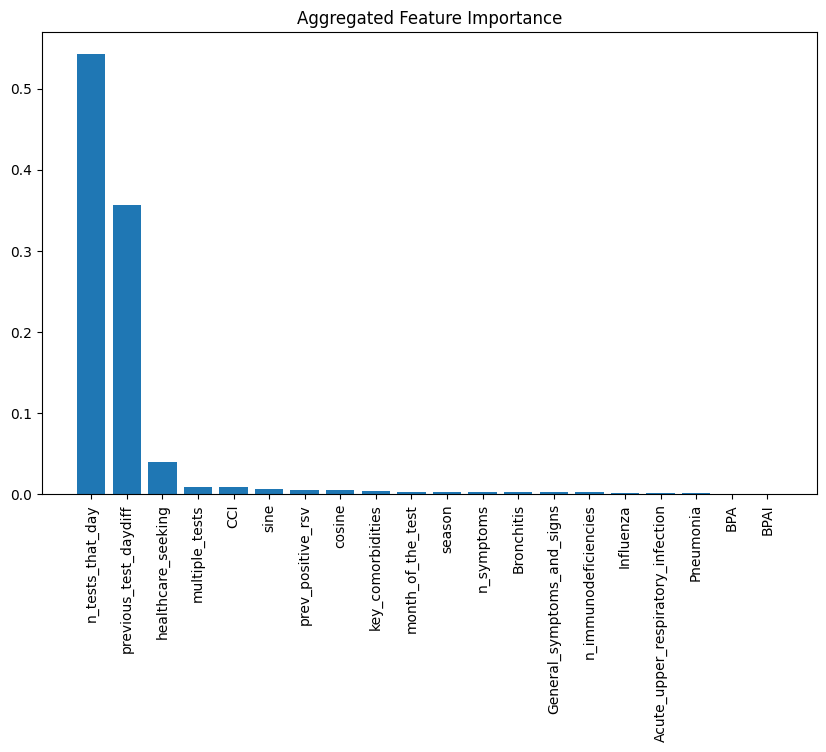

In [59]:

# Given feature_importances and feature_names
feature_importances = clf_nonOverlapping.feature_importances_
feature_names = pd.get_dummies(X_validation).columns

# Initialize a dictionary to hold the aggregated feature importances
feature_importances_v2 = defaultdict(float)

# A list of categorical features (you'll have to provide this)
categorical_features = X_validation.columns[X_validation.dtypes == 'category']

# Aggregate feature importances
for f, imp in zip(feature_names, feature_importances):
    root_name = f
    for cat_feat in categorical_features:
        if f.startswith(cat_feat):
            root_name = cat_feat
            break
    feature_importances_v2[root_name] += imp

# Convert aggregated feature importances into a sorted list
sorted_feature_importances_v2 = sorted(feature_importances_v2.items(), key=lambda x: x[1], reverse=True)

# Extracting the feature names (roots) and their aggregated importances
feature_names_v2 = [item[0] for item in sorted_feature_importances_v2]
feature_importances_v2_values = [item[1] for item in sorted_feature_importances_v2]

# Plotting
plt.figure(figsize=(10, 6))
plt.title("Aggregated Feature Importance")
plt.bar(range(len(feature_names_v2)), feature_importances_v2_values)
plt.xticks(range(len(feature_names_v2)), feature_names_v2, rotation=90)
plt.show()

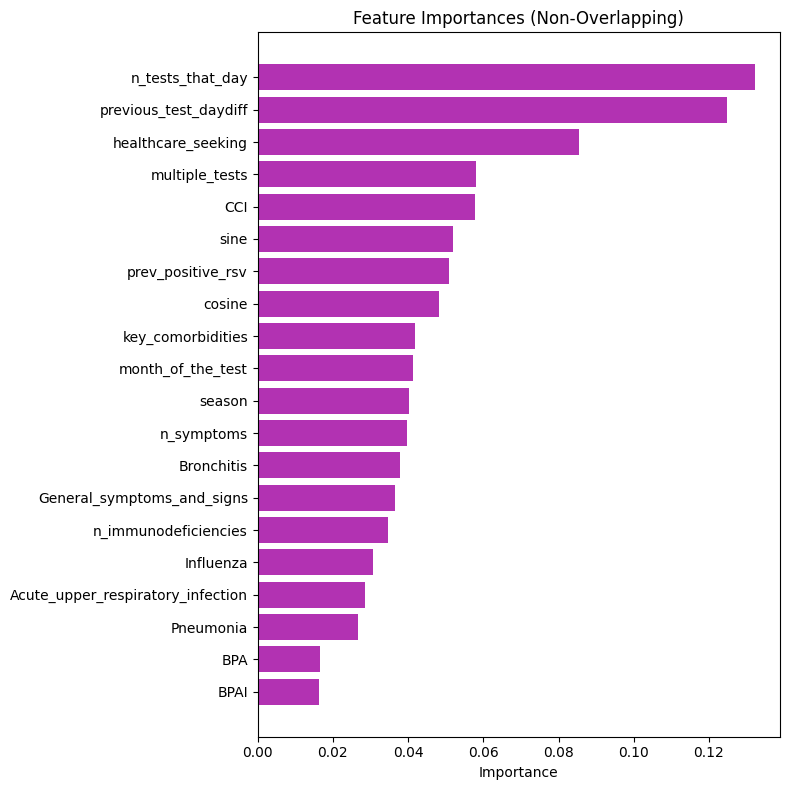

In [90]:
# 3.1. Feature importance plots
# Indicate feature names and categorical features
one_hot_roots = ['Bronchitis', 'Acute_upper_respiratory_infection', 
                 'healthcare_seeking', 'General_symptoms_and_signs', 
                 'Influenza', 'key_comorbidities', 'Pneumonia', 
                 'season', 'month_of_the_test', 'multiple_tests']
feature_names = X_train.columns

# Importances of the non-Overlapping model
clf_nonOverlapping= model_nonOverlapping.best_estimator_

feature_importances = clf_nonOverlapping.feature_importances_
feature_names = pd.get_dummies(X_validation).columns
categorical_features = X_validation.columns[X_validation.dtypes == 'category']

feature_importances_v2 = defaultdict(float)
for f, imp in zip(feature_names, feature_importances):
    root_name = f
    for cat_feat in categorical_features:
        if f.startswith(cat_feat):
            root_name = cat_feat
            break
    feature_importances_v2[root_name] += imp

sorted_feature_importances_v2 = sorted(feature_importances_v2.items(), key=lambda x: x[1], reverse=True)

## Extracting the feature names (roots) and their aggregated importances
feature_names_v2 = [item[0] for item in sorted_feature_importances_v2]
feature_importances_v2_values = [item[1] for item in sorted_feature_importances_v2]

# Importances of the Overlapping model
clf_Overlapping = model_Overlapping.best_estimator_
sorted_feature_names2, sorted_feature_values2 = get_sorted_importances(clf_Overlapping.feature_importances_, feature_names, one_hot_roots)

# Plot the features
light_black = (80/255, 80/255, 80/255)
light_purple = (178/255, 50/255, 178/255)
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, len(sorted_feature_names1) * 0.4))
# plot_feature_importances(ax1, sorted_feature_names1, sorted_feature_values1, 'Feature Importances (Non-Overlapping)', color = light_purple)
# plot_feature_importances(ax2, sorted_feature_names2, sorted_feature_values2, 'Feature Importances (Overlapping)', color = light_black)
# plt.tight_layout()
# plt.show()

fig, ax1 = plt.subplots(1, 1, figsize=(8, len(feature_names_v2) * 0.4))
plot_feature_importances(ax1, feature_names_v2[::-1], feature_importances_v2_values[::-1], 'Feature Importances (Non-Overlapping)', color = light_purple)
ax1.set_ylabel("")
plt.tight_layout()
plt.show()

#### 3.2. Partial Dependence Plots

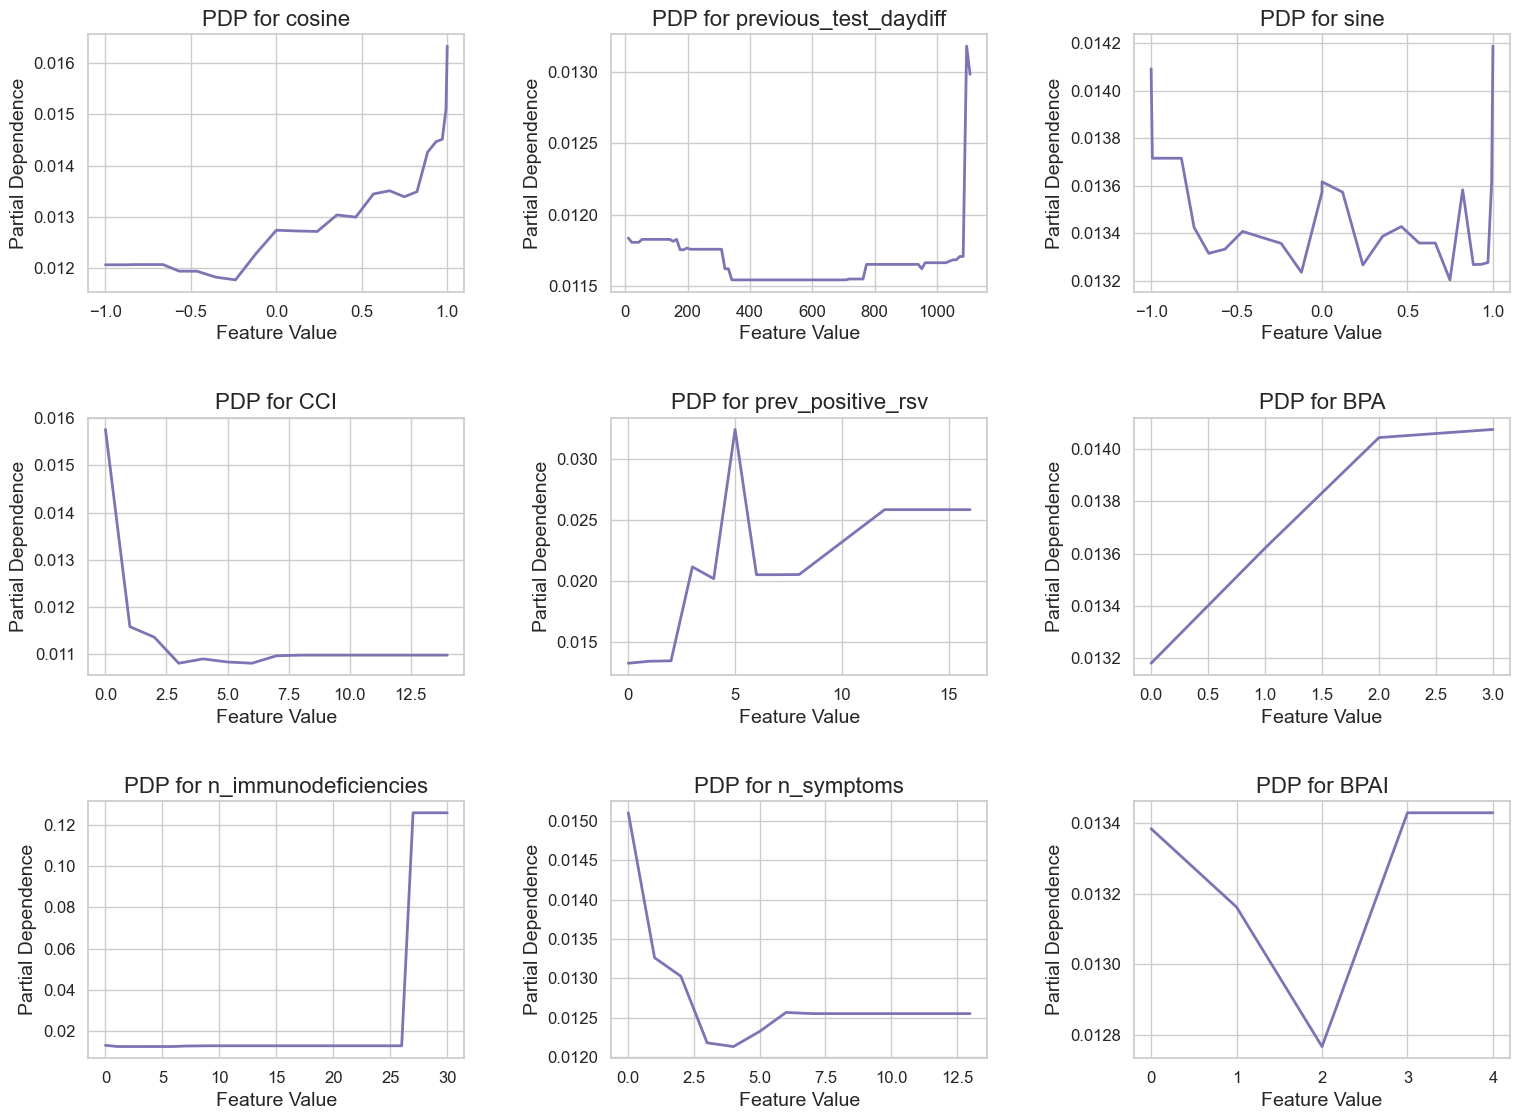

In [10]:

clf = model_nonOverlapping.best_estimator_
X_pdd = pd.get_dummies(X_validation)
numeric_features = X_validation.columns[(X_validation.dtypes == 'int64') | (X_validation.dtypes == 'float64')]
feature_names_v2.reverse()
sorted_feature_names = np.array(feature_names_v2, dtype=object)
numeric_features = np.array(numeric_features, dtype=object)

ordered_numeric_features = sorted_feature_names[np.isin(sorted_feature_names, numeric_features)]

sns.set(style="whitegrid")

# Plot the PDPs of numeric features
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for i, feature in enumerate(ordered_numeric_features):
    ax = axes[i // 3, i % 3]
    
    # Calculate PDP
    pdp_result = partial_dependence(clf, X_pdd, features=[feature])
    pdp_values = pdp_result['average']
    feature_values = pdp_result['values'][0]
    
    # Plot PDP
    ax.plot(feature_values, pdp_values.ravel(), label=feature, color='m', linewidth=2)
    ax.set_xlabel('Feature Value', fontsize=14)
    ax.set_ylabel('Partial Dependence', fontsize=14)
    ax.set_title(f'PDP for {feature}', fontsize=16)
    ax.tick_params(labelsize=12)

plt.tight_layout(pad=3.0)
plt.show()

C:\Users\angel\AppData\Local\Temp\ipykernel_29432\3817220745.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_dummy_cols)


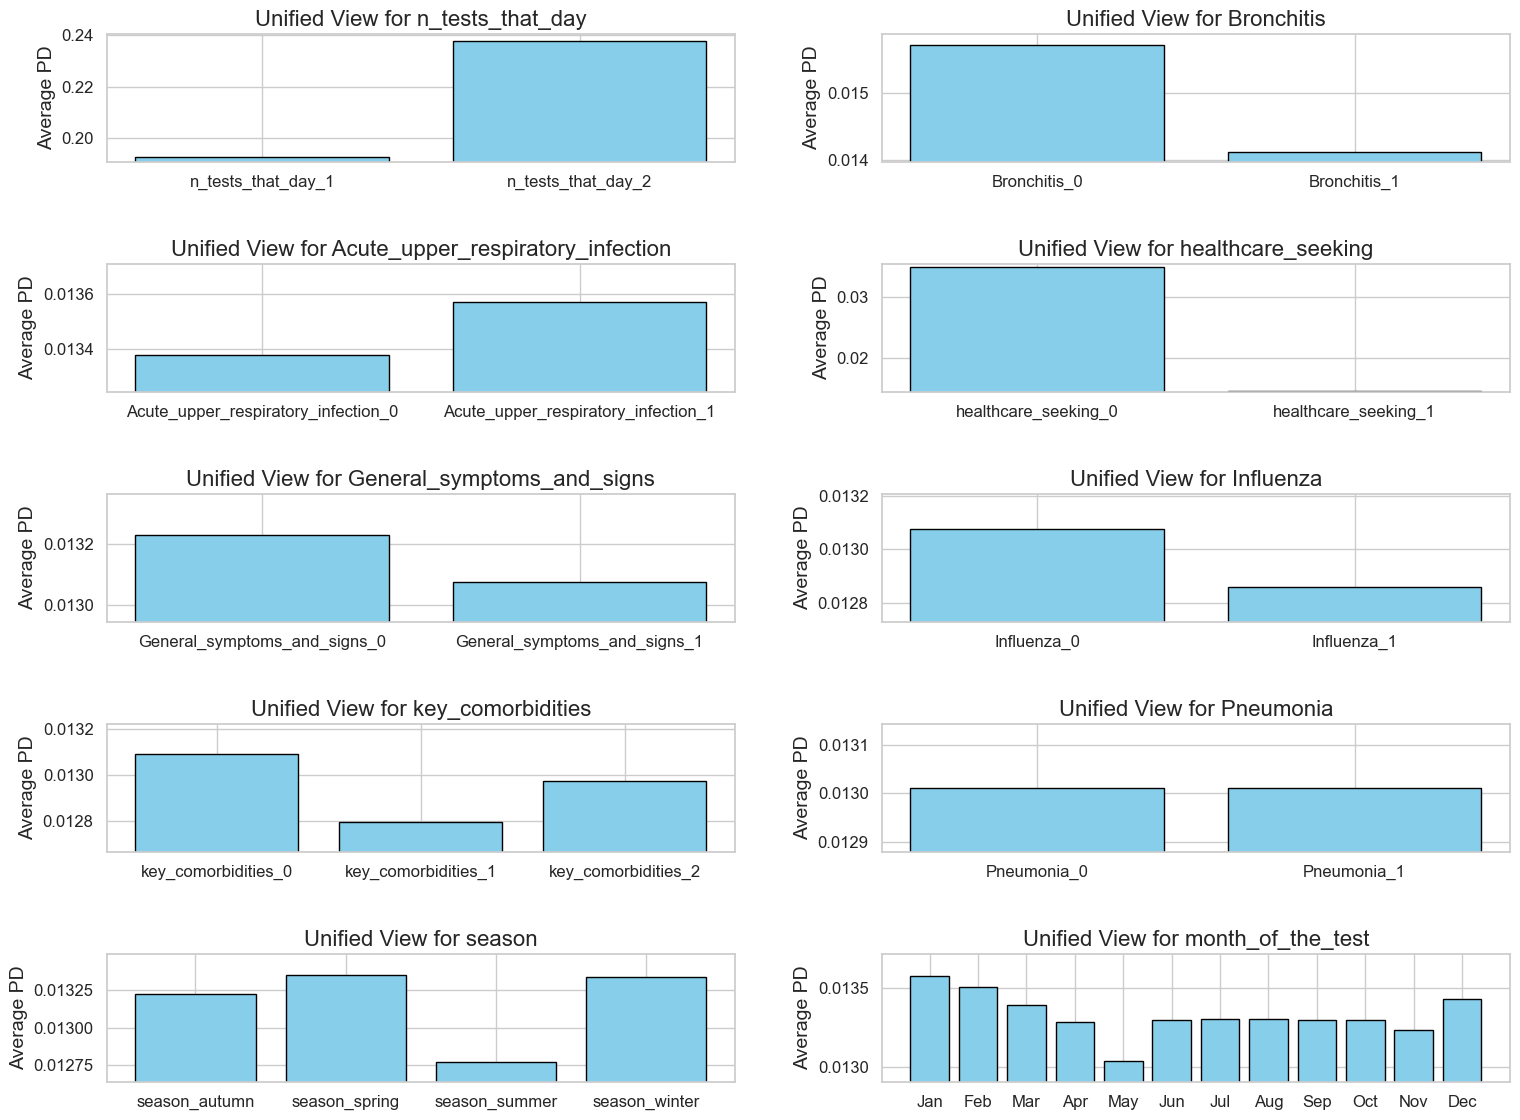

In [66]:
## 3.2. Partial dependence plots, now for categorical variables

dummy_cols_list = [
    ['n_tests_that_day_1', 'n_tests_that_day_2'], ['Bronchitis_0',
    'Bronchitis_1'], ['Acute_upper_respiratory_infection_0',
    'Acute_upper_respiratory_infection_1'], ['healthcare_seeking_0',
    'healthcare_seeking_1'], ['General_symptoms_and_signs_0',
    'General_symptoms_and_signs_1'], ['Influenza_0', 'Influenza_1'],
    ['key_comorbidities_0', 'key_comorbidities_1', 'key_comorbidities_2'],
    ['Pneumonia_0', 'Pneumonia_1'], ['season_autumn', 'season_spring',
    'season_summer', 'season_winter'], ['month_of_the_test_1',
    'month_of_the_test_2', 'month_of_the_test_3', 'month_of_the_test_4',
    'month_of_the_test_5', 'month_of_the_test_6', 'month_of_the_test_7',
    'month_of_the_test_8', 'month_of_the_test_9', 'month_of_the_test_10',
    'month_of_the_test_11', 'month_of_the_test_12']
]

fig, axes = plt.subplots(5,2, figsize=(16, 12))
num_plots = 10
for i, dummy_cols in enumerate(dummy_cols_list):
    ax = axes[i // 2, i % 2]

    pdp_averages = []
    for col in dummy_cols:
        pdp_result = partial_dependence(clf, X_pdd, features=[col])
        average_pdp = np.mean(pdp_result['average'])
        pdp_averages.append(average_pdp)
    
    # Now pdp_averages contains the average pdp for each category
    y_min = min(pdp_averages) * 0.99
    y_max = max(pdp_averages) * 1.01

    ax.bar(dummy_cols, pdp_averages, color='skyblue', edgecolor='black')
    ax.set_ylabel('Average PD', fontsize=14)
    title_text = dummy_cols[0].rsplit('_', 1)[0]
    ax.set_title(f'Unified View for {title_text}', fontsize=16)
    ax.set_ylim([y_min, y_max])
    ax.tick_params(axis='both', which='major', labelsize=12)

    if i == num_plots - 1:  # Change of names in the categories of the months of the year
        new_dummy_cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec']
        ax.set_xticklabels(new_dummy_cols) 
    
plt.tight_layout(pad=3.0)

plt.show()

#### 3.3. SHAP values

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


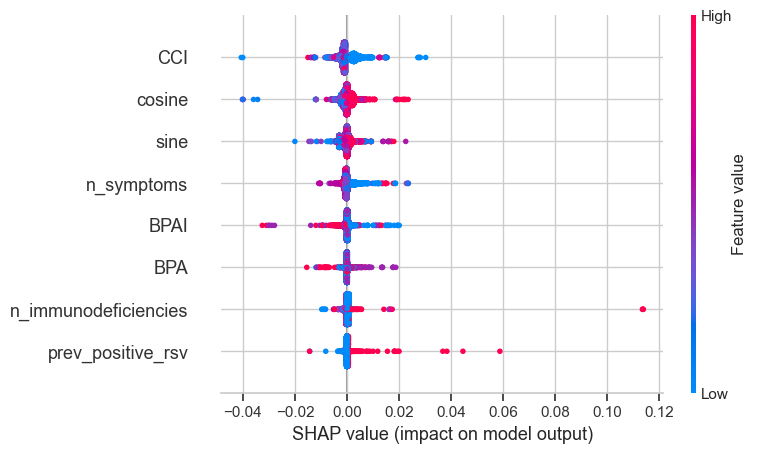

In [25]:
X_shap = X_validation.loc[:,numeric_features]
X_shap = pd.get_dummies(X_validation)

numeric_features_shap = list(numeric_features).copy()
numeric_features_shap.remove('previous_test_daydiff')
numeric_indices = [X_shap.columns.get_loc(col) for col in numeric_features_shap]

explainer = shap.TreeExplainer(clf)
shap_values_single = explainer.shap_values(X_shap.iloc[0, :])[1] # 'Positive' class  
shap_values_multiple = explainer.shap_values(X_shap)[1] 

# Filtering in numeric features only
shap_values_single_numeric = shap_values_single[numeric_indices]
shap_values_multiple_numeric = shap_values_multiple[:, numeric_indices]

shap.summary_plot(shap_values_multiple_numeric, X_shap[numeric_features_shap])